
# Classify Land Cover Using Scikit-learn in  Open Source Python

Authors: Leah Waser, Joe McGlinchy, Natasha Stavros

This lesson has been adapted from those found here: https://github.com/ceholden/open-geo-tutorial

This image is a subset of a Landsat 7 image containing the 7 bands on this sensor rearranged in order of wavelength (e.g., Landsat 7's second SWIR channel comes before thermal channel in our stack). The last band in this image is a cloud and cloud shadow mask from Fmask.

Eight spectral bands, including a pan and thermal band:

    Band 1 Visible (0.45 - 0.52 µm) 30 m
    Band 2 Visible (0.52 - 0.60 µm) 30 m
    Band 3 Visible (0.63 - 0.69 µm) 30 m
    Band 4 Near-Infrared (0.77 - 0.90 µm) 30 m
    Band 5 Short-wave Infrared (1.55 - 1.75 µm) 30 m
    Band 6 Thermal (10.40 - 12.50 µm) 60 m Low Gain / High Gain
    Band 7 Mid-Infrared (2.08 - 2.35 µm) 30 m
    Band 8 Panchromatic (PAN) (0.52 - 0.90 µm) 15 m

So the order is:

1.    Band 1 Visible (0.45 - 0.52 µm) 30 m
2.    Band 2 Visible (0.52 - 0.60 µm) 30 m
3.    Band 3 Visible (0.63 - 0.69 µm) 30 m
4.    Band 4 Near-Infrared (0.77 - 0.90 µm) 30 m
5.    Band 5 Short-wave Infrared (1.55 - 1.75 µm) 30 m
6.    Band 7 Mid-Infrared (2.08 - 2.35 µm) 30 m
7.    Band 6 Thermal (10.40 - 12.50 µm) 60 m Low Gain / High Gain
8.  cloud mask

## Introduction
In this lesson you will classify a Landsat image using a supervised classification approach which incorporates training data. You will use the [RandomForest (Brieman 2001)](http://link.springer.com/article/10.1023/A:1010933404324) ensemble decision tree algorithm by [Leo Breiman and Adele Cutler](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm) to perform the classification. The RandomForest algorithm is popular in the field of remote sensing given it's often faster than other machine learning approaches such as Support Vector Machines (SVM) which can be more computationally intense. RandomForest is nice entry into the world of machine learning for classification and regression.

A few good resources for understanding RandomForest include:
* [Breiman, Leo. 2001. Random Forests. Machine Learning 45-1: 5-32.](http://link.springer.com/article/10.1023/A:1010933404324)
* [Wikipedia - Random Forest](http://en.wikipedia.org/wiki/Random_forest)
* [Breiman and Cutler's website](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#workings)
* [Blog entry from ŷhat](http://blog.yhathq.com/posts/random-forests-in-python.html)


A **decision tree** is an alternative to a linear model that is better suited to data that are non-linear.
![Decision tree vs. Linear Regression](https://dimensionless.in/wp-content/uploads/RandomForest_blog_files/figure-html/reg_vs_dt.png)

The RandomForest algorithm uses the ensemble result of a **large number of decisions 
trees** (a forest of trees!) rather than use the predictions of a single decision 
tree. The "Random" part of the name comes from the term 
"bootstrap aggregating", or "bagging". What this means is that each tree 
within the forest only gets to train on some subset of the full training 
dataset (the subset is determined by sampling with replacement). The elements 
of the training data for each tree that are left unseen are held "out-of-bag" 
for estimation of accuracy. Randomness also helps decide which feature input 
variables are seen at each node in each decision tree. Once all individual 
trees are fit to the random subset of the training data, using a random set 
of feature variable at each node, the ensemble of them all is used to give the 
final prediction. 

In the classification mode, this means that if you were to have 5 landcover classes being predicted using 500 trees, the output prediction would be the class that has the most number of the 500 trees predicting it. The proportion of the number of trees that voted for the winning class can be a diagnostic of the representativeness of your training data relative to the rest of the image. Taking the 500 trees example, if you have pixels which are voted to be in the "Grassland" land cover class by 475 of 500 trees, you could say that this was a relatively certain prediction. On the other hand, if you have a pixel which gets 250 votes for "Grassland" and 225 votes for "Shrub", you could interpret this as either an innately confusing pixel (maybe it is a mixed pixel contains both grass and shrubs) or as an indicator that you need more training data samples that represent these types of pixels.


Finally, Random Forest has some other benefits:
* It gives you a measure of "variable importance" which relates how useful your input features (e.g. spectral bands) were in the classification
* The "out-of-bag" samples in each tree can be used to validate each tree. Grouping these predicted accuracies across all trees can [sometimes give you an unbiased estimate of the error rate](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#ooberr) similar to doing cross-validation.
* It can be used for regressions, unsupervised clustering, or supervised classification
* Available in many popular languages, including Python, R, and MATLAB
* Free, open source, and fast

## Use scikit-learn in Python To Run Random Forest

In this lesson you will use the Random Forest implementation provided by the [scikit-learn](http://scikit-learn.org) Python library. `Scikit-learn` is a machine learning library that provides simple-to-implement and consistent interfaces to many of the most popular machine learning algorithms. It is built on top of the pre-existing scientific Python libraries, including NumPy, SciPy, and matplotlib. The number of available methods for accomplishing any task contained within the library is a strength. No single algorithm is best for all tasks under all circumstances, and `scikit-learn` helps you understand this by abstracting the details of each algorithm to simple consistent interfaces. For example:

![https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png)

This figure shows the classification predictions and the decision surfaces produced for three classification problems using 9 different classifiers. 

One of the challenges with `skikit-learn` to be aware of is you may run into resource issues  when starting to process larger volumes of data. However, for this lesson, you will be working with a single landsat scene with the goal of learning how to implement a RandomForest  model.

## Prepare Your Remote Sensing Data For Processing

To begin, you will open both the training data (in raster format) and 
the Landsat scene that you wish to classify.



### A FEW  NOTES

* We could just use vector Format training data? 
   * You could also iterate through each feature poly and pull the pixels within that overlap the shape and then process the data that way to fit your model. Right now i'm just using the already created data but perhaps i'll do it this was next as it seems more efficient than creating an entirely new raster object.     

* Below  you use scikit learn's has a `train_test_split` method - to specify the % of data to split out? 70/30  example train/test - a problem with this is it may not give you equal class representation. <leah will look more  closely into this> 
    
* dataframe needs to have the features and the label

* If you were doing this for many scenes you probably want to spread your training data across multiple scenes... to generalize better.. this is just a single scene example.
    
    <Might be good to pull together some best practices for training data and such that can be used as a starting place>

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import rioxarray as rxr
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import earthpy as et
import earthpy.plot as ep
import seaborn as sns
import xarray as xr

To begin, open up the Landsat scene which is  stacked here with the 8th band
being the cloud mask.

In [3]:
# Open the stacked image (we could create this using earthpy stack or rioxarray)
landsat_url = (
    "https://github.com/ceholden/open-geo-tutorial/blob/master/example/"
    "LE70220491999322EDC01_stack.gtif?raw=true")
landsat_path = et.data.get_data(url=landsat_url)
landsat_raw_xr = rxr.open_rasterio(landsat_path)
landsat_raw_xr

<xarray.DataArray (band: 8, y: 250, x: 250)>
[500000 values with dtype=int16]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8
  * x            (x) float64 4.624e+05 4.624e+05 ... 4.699e+05 4.699e+05
  * y            (y) float64 1.742e+06 1.742e+06 ... 1.734e+06 1.734e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    -9999.0
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('band 1 reflectance', 'band 2 reflectance', 'band 3 refle...

In [5]:
# Extract the cloud mask - here there are no clouds in this scene
cl_mask = landsat_raw_xr[7]
np.unique(cl_mask)

array([0], dtype=int16)

In [6]:
# Drop the 8th cloud mask - note this is an artifact of the data being not ideal
# This is not a typical landsat workflow which would be all .tif files
landsat_bands_xr = landsat_raw_xr[0:7]
landsat_bands_xr

<xarray.DataArray (band: 7, y: 250, x: 250)>
[437500 values with dtype=int16]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7
  * x            (x) float64 4.624e+05 4.624e+05 ... 4.699e+05 4.699e+05
  * y            (y) float64 1.742e+06 1.742e+06 ... 1.734e+06 1.734e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    -9999.0
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('band 1 reflectance', 'band 2 reflectance', 'band 3 refle...

In [7]:
# Apply the mask - in this case the scene is cloud free according to the layers
# that we have
landsat_xr = landsat_bands_xr.where(~cl_mask)
landsat_xr

<xarray.DataArray (band: 7, y: 250, x: 250)>
array([[[ 569.,  526.,  569., ...,  311.,  289.,  311.],
        [ 568.,  589.,  568., ...,  267.,  332.,  332.],
        [ 546.,  525.,  589., ...,  311.,  311.,  311.],
        ...,
        [ 499.,  543.,  478., ...,  306.,  349.,  372.],
        [ 520.,  520.,  543., ...,  328.,  372.,  393.],
        [ 543.,  564.,  543., ...,  393.,  414.,  436.]],

       [[ 886.,  886.,  798., ...,  452.,  452.,  430.],
        [ 886.,  929.,  907., ...,  430.,  452.,  452.],
        [ 864.,  886.,  928., ...,  452.,  475.,  475.],
        ...,
        [ 851.,  829.,  829., ...,  473.,  494.,  584.],
        [ 829.,  829.,  829., ...,  473.,  628.,  628.],
        [ 829.,  851.,  829., ...,  607.,  673.,  628.]],

       [[ 758.,  758.,  776., ...,  356.,  297.,  337.],
        [ 815.,  853.,  910., ...,  318.,  337.,  395.],
        [ 834.,  834.,  891., ...,  356.,  395.,  356.],
        ...,
...
        ...,
        [2546., 2773., 2873., ..., 1791., 1817., 1918.],
        [2722., 2823., 2748., ..., 1438., 2219., 2345.],
        [2823., 2873., 2773., ..., 2294., 2597., 2294.]],

       [[ 988.,  988.,  961., ...,  780.,  647.,  674.],
        [1014., 1014., 1014., ...,  674.,  594.,  727.],
        [ 988.,  988.,  988., ...,  727.,  727.,  753.],
        ...,
        [1124., 1387., 1414., ...,  753.,  753.,  780.],
        [1283., 1387., 1361., ...,  568., 1045., 1018.],
        [1440., 1467., 1387., ..., 1230., 1440., 1045.]],

       [[2686., 2686., 2686., ..., 2487., 2487., 2436.],
        [2686., 2686., 2686., ..., 2487., 2487., 2487.],
        [2637., 2637., 2637., ..., 2487., 2487., 2487.],
        ...,
        [2785., 2735., 2735., ..., 2537., 2537., 2587.],
        [2785., 2785., 2785., ..., 2587., 2587., 2587.],
        [2785., 2785., 2785., ..., 2686., 2686., 2637.]]])
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7
  * x            (x) float64 4.624e+05 4.624e+05 ... 4.699e+05 4.699e+05
  * y            (y) float64 1.742e+06 1.742e+06 ... 1.734e+06 1.734e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    -9999.0
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('band 1 reflectance', 'band 2 reflectance', 'band 3 refle...

### Open  the  Training  Data

In machine learning world, a label is equivilent to a categorical class. It's the thing that you want to classify or find in your data. In this example the classes represent landcover classes.

The training data contain 5 "labels":

* 1 - forest
* 2 - water
* 3 - herbaceous
* 4 - barren
* 5 - urban

In [14]:
# Open the training data
training_url = (
    "https://github.com/ceholden/open-geo-tutorial/blob/master/example/"
    "training_data.gtif?raw=true")
training_path = et.data.get_data(url=training_url)
training_raw_xr = rxr.open_rasterio(training_path).squeeze()

# Apply cloud mask
training_xr = training_raw_xr.where(~cl_mask)
training_xr

<xarray.DataArray (y: 250, x: 250)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * x            (x) float64 4.624e+05 4.624e+05 ... 4.699e+05 4.699e+05
  * y            (y) float64 1.742e+06 1.742e+06 ... 1.734e+06 1.734e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [17]:
# List of classes found in the data
classes = ["Unclassified",
           "Forest",
           "Water",
           "Herbaceous",
           "Barren",
           "Urban"]

# Define color map
colors = ["white",
          "darkgreen",
          "blue",
          "yellowgreen",
          "brown",
          "grey"]

# Create a colormap
cmap = ListedColormap(colors)

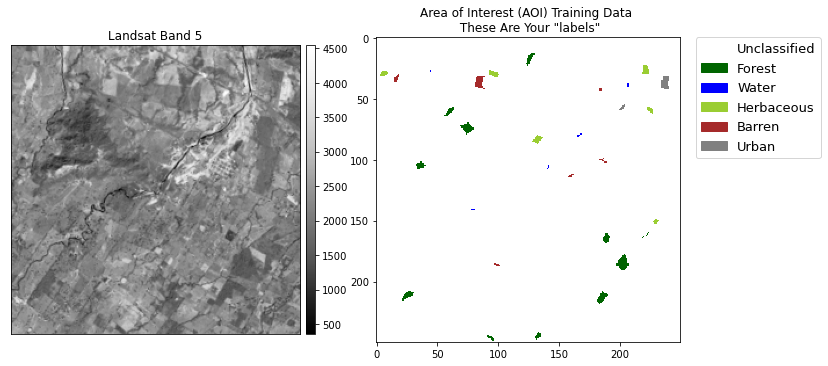

In [18]:
# Plot the data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ep.plot_bands(landsat_xr[4], ax=ax1)
ax1.set_title('Landsat Band 5')

im = ax2.imshow(training_xr.values,
                cmap=cmap,
                interpolation='none')
ep.draw_legend(im_ax=im,
               titles=classes)
ax2.set_title(
    'Area of Interest (AOI) Training Data \n These Are Your "labels"')

plt.show()

Note in the plot above-right, the colored boxes represent pixels that have been 
manually classified. This manual process often entails working in a GIS system
such as QGIS, and digitizing or drawing boxes around areas in an image that 
represent the landcover types of interest. The process of creating training 
data is often a manual process.



### Pair the Labeled Y Data (training  Data) with x (the  Feature Inputs)  To Build A Model
Now that you have the image that you want to classify (your x feature inputs), 
and the Are of Interest (AOI) with the land cover labels (your Y labeled data), 
you need to change the structure of the data so the labels and image data
can be used by Random Forest.

Typically this involves flattening the data into a single dimension array. 

The training data represent pixels. Each pixel is considered a sample.
Remember that your training data are a single band raster but your landsat
scene represents multiple bands. Each pixel in the training data will overlap
with a single pixel in each band of your landsat scene.

In [19]:
# Calculate the number of trained pixels or how many training data samples do you have
n_samples = (training_xr > 0).sum().item()
# Each pixel a sample
print('You have {} total training samples (or pixels).'.format(n_samples))

You have 718 total training samples (or pixels).


In [20]:
# Calculate pixels
unique_values, pix_counts = np.unique(training_xr, return_counts=True)

training_counts = pd.DataFrame({'vals': unique_values,
                                'counts': pix_counts})

training_counts

,vals,counts
0,0.0,61782
1,1.0,383
2,2.0,16
3,3.0,145
4,4.0,106
5,5.0,68


In this example, you can see that you don't have a consistent number of 
samples for each landcover class. Class 2  is particularly poorly represented.

If this were a real  project, you may want to go back to the drawing board and
create additional training data for class 2 (and possibly 5). For our 
example today, what you have is enough!

Also remember that in this training dataset values equal to **0** are missing labels
**values > 0** are labeled pixels which represent a class. Only the pixels with a label
will be used to fit your model.

Below you extract the pixels for which you have training data for.

x represents your landsat scene pixels. This is your test data that you will use 
to build your model on. y represents your classified training data. The x and y 
data combined will allow you to fit the RandomForest model. 

Notice that the data below are flattened into one long array. 
Each landsat band is a single row of values, and your labeled  data are a 
single long array. This is the format that `scikit-learn` requires.

In [22]:
# We will need a "x" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows

x = landsat_xr.values[:, training_xr.values > 0]
y = training_xr.values[training_xr.values > 0]

print('The shape of our x array: {}'.format(x.shape))
print('The shape of our y array: {}'.format(y.shape))

The shape of our x array: (7, 718)
The shape of our y array: (718,)


Below  the data are transposed. xarray brings the data in - in band  order - 
the bands are the first dimension. scikitlearn prefers the data to be in pixel
order - with the reflectance data first which matches our training data. 

In [23]:
# Notice that the data are not in the same dimension order -  bands are first
x.shape, y.shape

((7, 718), (718,))

In [24]:
# Transpose data
x = x.transpose()
x.shape, y.shape

((718, 7), (718,))

In [25]:
# Create a   pairplot to explore separability of classes by band  combinations
all_bands_df = pd.DataFrame(data=x,
                         columns=[1, 2, 3, 4, 5, 6, 7])
all_bands_df["class"] = y
all_bands_df

,1,2,3,4,5,6,7,class
0,348.0,507.0,346.0,3001.0,1611.0,646.0,2587.0,1.0
1,369.0,529.0,365.0,3030.0,1662.0,726.0,2587.0,1.0
2,348.0,486.0,365.0,3143.0,1662.0,646.0,2637.0,1.0
3,327.0,441.0,327.0,3002.0,1561.0,646.0,2537.0,1.0
4,327.0,463.0,346.0,2887.0,1486.0,567.0,2537.0,1.0
...,...,...,...,...,...,...,...,...
713,306.0,427.0,296.0,3185.0,1413.0,541.0,2537.0,1.0
714,285.0,450.0,277.0,3470.0,1413.0,541.0,2537.0,1.0
715,349.0,607.0,454.0,3783.0,2044.0,806.0,2587.0,1.0
716,306.0,427.0,336.0,3155.0,1463.0,568.0,2637.0,1.0


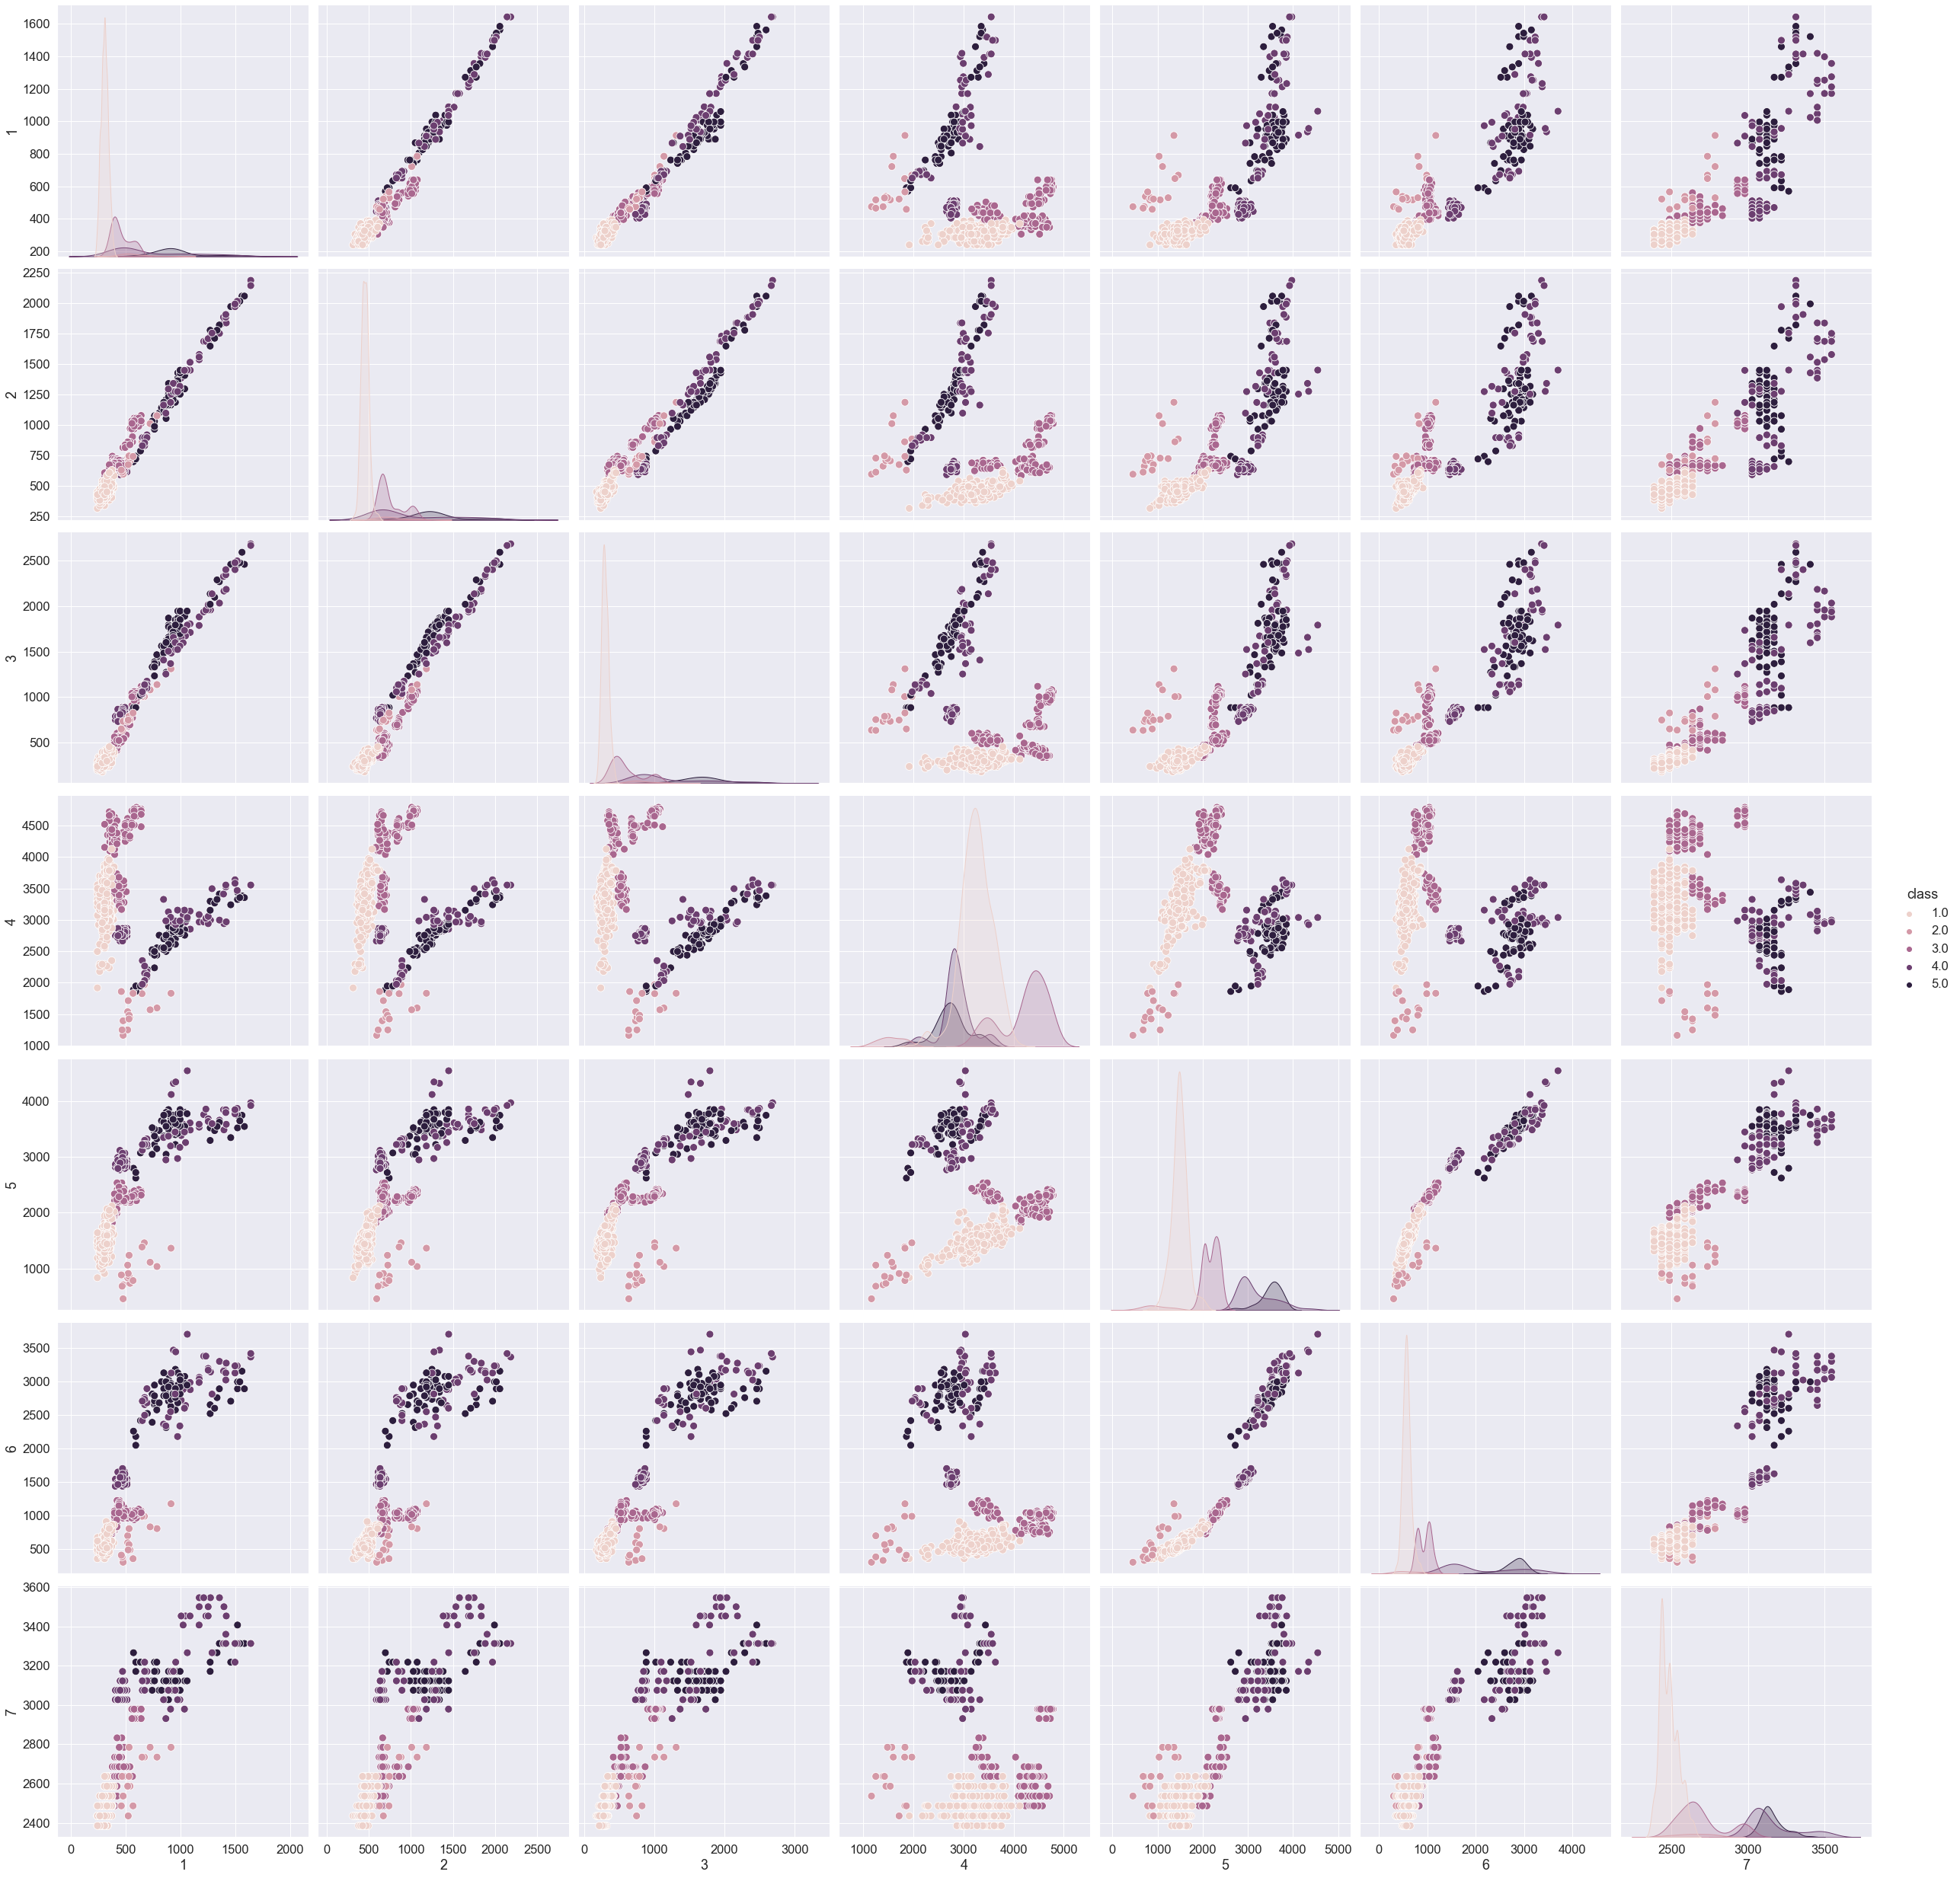

In [26]:
sns.set(font_scale=1.5)
sns.pairplot(
    all_bands_df, 
    height=5,
    plot_kws={"s": 100},
    hue="class")
plt.show()

In [27]:
final_classes = [
    "Forest", 
    "Water", 
    "Herbaceous",
    "Barren", 
    "Urban"]

In [ ]:
# Define color map
colors = ["gray", "blue", "yellowgreen", "g", "darkgreen"]
cmap = ListedColormap(colors)

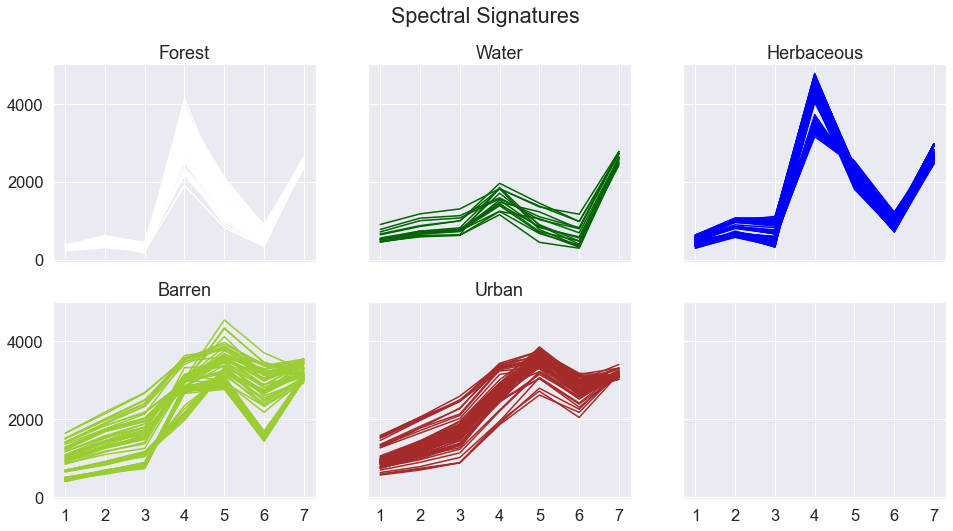

In [29]:
f, axs = plt.subplots(2, 3, figsize=(16, 8), 
                      sharey=True, sharex=True)
for group, df in all_bands_df.groupby("class"):
    the_group = int(group-1)
    axs_ravel = axs.ravel()
    flipped = df.T
    flipped.drop(flipped.tail(1).index, inplace=True)
    flipped.plot(color=colors[the_group],
                 ax=axs_ravel[the_group],
                 legend=False, 
                 title=final_classes[the_group])
    
plt.xticks(np.arange(1, 8, 1.0))
plt.suptitle("Spectral Signatures")
plt.show()

## Train the Random Forest Model On All Training Data

Now that you have your x matrix of feature inputs (the spectral bands) and 
your y array (the labels), you can train your model. Note that below you 
are training your model on all of your data

Visit [this web page to find the usage of RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from `scikit-learn`.



In [30]:
# Initialize our model with 500 trees- based upon previous work??
rf = RandomForestClassifier(n_estimators=500,
                            oob_score=True)

# Fit our model to training data
rf = rf.fit(x, y)
rf

RandomForestClassifier(n_estimators=500, oob_score=True)

#### Random Forest diagnostics

With our Random Forest model fit, we can check out the "Out-of-Bag" (OOB) prediction score:

In [31]:
print('Our OOB prediction of accuracy is: {oob}%'.format(
    oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 98.32869080779945%


### What Bands Are Most Important?


To help you better understand which spectral bands were important in the model, 
you can look at the feature importance scores - see below.





In [32]:
bands = [1, 2, 3, 4, 5, 6, 7]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.13108941912496933
Band 2 importance: 0.18108856263778905
Band 3 importance: 0.12652952754929883
Band 4 importance: 0.0961436768341304
Band 5 importance: 0.20455244474606146
Band 6 importance: 0.16608388001904184
Band 7 importance: 0.09451248908870902


With the largest weights, it looks like the SWIR1 and the Green bands 
were the most useful bands for classification. Not surprising, the 
thermal band is not very useful because there isn't much delineation of 
land cover type with temperature if you only look with a very small area 
not influenced by an Urban Heat Island.

## Confusion Matrix 

Next you will generate a  look at a crosstabulation to see the class confusion matrix. To do 
so, we will 
use Pandas. 

More backgroup here (maybe this background goes in a previous lesson)
that way this  lesson can focus on only running random forest.
* what is a confusion  matrix
*  producer  vs cons accuracy

### Classification Report

Below you create a confusion matrix using Pandas and the model outputs.
A confusion matrix allows you to identify several error metrics:

1. How many pixels were correctly classified - overall accuracy.  
2. **Errors of Omission:** Errors of omission refer to pixels that were not correctly classified and thus left out (or omitted) from the correct class in the classified map. So for example lets pretend pixel 1 was supposed to be forest but was instead classified as shrub. Pixel 1 would contribute to the ommission error (also known as Type 1 error) associated with forest as it was left out of the forest class. 
3. **Errors of Commission:** Errors of commission refer to pixels in the classified map that  were incorrect added to, (or committed to) a class in your final map. So pixel 1 was  also  committed to  the  shrub class when it really was forest. 


So above, pixel 1  was ommitted from forest yielding a lower number of 
forest classified pixels in your final classification. Pixel 1 was committed 
to shrub and thus yielding a higher number of shrub-classified pixels in your 
final map.

![Error or confusion matrix](http://gis.humboldt.edu/OLM/Courses/GSP_216_Online/images/error-matrix.png)

* <a href="http://gis.humboldt.edu/OLM/Courses/GSP_216_Online/lesson6-2/metrics.html" target="_blank">Read more about confusion / error matrices.</a>

Below you generate a confusion matrix using pandas and the outputs of your 
model.

In [34]:
# Create the confusion matrix
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(x)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'],
                  df['predict'],
                  margins=True))
print(classes[1:])

predict  1.0  2.0  3.0  4.0  5.0  All
truth                                
1.0      383    0    0    0    0  383
2.0        0   16    0    0    0   16
3.0        0    0  145    0    0  145
4.0        0    0    0  106    0  106
5.0        0    0    0    0   68   68
All      383   16  145  106   68  718
['Forest', 'Water', 'Herbaceous', 'Barren', 'Urban']


### Skikit-learn  Classification Reports

Scikit-learn will also produce a classification report that 
shows you the precision of the classification by class.

Note that in this example, our precision and accuracy are 100%. 

Any ideas why that is the case? Can our model really be perfect?

<link to all models are wrong??>

In [35]:
print(classification_report(y, rf.predict(x), target_names=final_classes))

              precision    recall  f1-score   support

      Forest       1.00      1.00      1.00       383
       Water       1.00      1.00      1.00        16
  Herbaceous       1.00      1.00      1.00       145
      Barren       1.00      1.00      1.00       106
       Urban       1.00      1.00      1.00        68

    accuracy                           1.00       718
   macro avg       1.00      1.00      1.00       718
weighted avg       1.00      1.00      1.00       718



###  100%  Accuracy  Is  Not  Real 

Above  you have results that suggest  that your model is 100% accurate. It's 
important to know that a machine l earning algorithm can be easily overfit given  many different  scenarios.

In this case, we did two  things

1. You used a large number of trees (500) within a machine learning algorithm to best figure out the pattern in our training data. Given the  number of trees and associated training data, this algorithm precisely learned what you gave it. 
2. You also validated our machine learning algorithm using the training data that we provided it. You can expect our model to thus produce a 100% accuracy on data it had already seen. 

To address both of these issues, you will do two things below.

1. First you will apply a small number of trees to fit your model.  

2. You can apply a a crossvalidation approach where you train on a subset the data. You then  predict and assess the accuracy using the sections that you didn't train it on. To get a robust measure of the performance, you can run this using random subsets x number of times.

Below, you create a subset from which you can train and test your mode.

## Cross Validation: Create a Test and  A Training Dataset

Above you created a model however, you used all of your training data to build
the model. This approach makes it difficult to independently test the results 
of your model and corectly assess accuracy. A common approach to test your model, is 
to:

1. pull some of your training data out and set it aside. 
2. Use the rest of the data to fit your model. 
3. And then use the data that you set aside for testing and cross validation.

You also adjust the number of decision trees used to fit your model.

Below you will implement that workflow using the `trail_test_split`  function 
in `scikit-learn`. Note that you could run this workflow via functions and 
loops several times to return a more 

In [36]:
# Split out the data for training keeping 30% for testing and cross validation
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.30,
                                                    random_state=42)

In [37]:
# Calculate counts for training classes
pd.DataFrame(np.unique(y_train, return_counts=True))

,0,1,2,3,4
0,1.0,2.0,3.0,4.0,5.0
1,268.0,14.0,95.0,70.0,55.0


Here you fit the model using fewer estimators. Note that your fit is still
fairly high.  

<Is this fit normal?? it seems pretty high>

In [38]:
# Fit model to training data
rf_train = RandomForestClassifier(n_estimators=50,
                                  oob_score=True)

# Fit our model to training data
rf_train = rf_train.fit(x_train, y_train)
rf_train

RandomForestClassifier(n_estimators=50, oob_score=True)

In [39]:
# Calculate accuracy of classfier
print('Our OOB prediction of accuracy is: {oob}%'.format(
    oob=rf_train.oob_score_ * 100))

Our OOB prediction of accuracy is: 98.00796812749005%


## Run Model on Test Data
Below, you run the model built using the training data on the test data.
Because you have validation data available to match the test data output. 
You can calculate the accuracy of the trained model  compared to the expected
"truth" or real values for each pixel. 

In [40]:
# Apply model to test data
class_prediction = rf_train.predict(x_test)

Notice that the prediction and test data have the same shape. Each value in 
each array represents the same pixel location in your original image. This 
dataset allows you to calculate the model accuracy and build a confusion
matrix.

In [41]:
class_prediction.shape, y_test.shape

((216,), (216,))

## What importance value levels are good enough?

In [ ]:
# Bands 2 and 5 have the highest "importance"
bands = [1, 2, 3, 4, 5, 6, 7]

for b, imp in zip(bands, rf_train.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

## Create Your Confusion Matrix

A confusion matrix is one way of understanding which pixels were 
classified correctly and which weren't. In the dataframe below, 
The top row of headers represents the predicted values.

The  first column header represents the expected truth values.

Any pixels whose values align with both predicted and truth, are considered
correctly classified. The predicted values equal the actual values (the truth).

Notice below that two pixels were mixclassified. One pixel who's truth 
value is 5 was classified as 4. Another's truth value of 4 was predicted
as 5. 

In [42]:
#  Why is this  still 100%?
print(classification_report(y_test,
                            rf.predict(x_test),
                            target_names=final_classes))

              precision    recall  f1-score   support

      Forest       1.00      1.00      1.00       115
       Water       1.00      1.00      1.00         2
  Herbaceous       1.00      1.00      1.00        50
      Barren       1.00      1.00      1.00        36
       Urban       1.00      1.00      1.00        13

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



In [43]:
# Create confusion matrix
df = pd.DataFrame()
df['truth'] = y_test
df['predict'] = rf_train.predict(x_test)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'],
                  df['predict'],
                  margins=True))

predict  1.0  2.0  3.0  4.0  5.0  All
truth                                
1.0      115    0    0    0    0  115
2.0        0    2    0    0    0    2
3.0        0    0   50    0    0   50
4.0        0    0    0   34    2   36
5.0        0    0    0    1   12   13
All      115    2   50   35   14  216


## Run the Classifier on the Entire Landsat  Scene

Above, you developed the model  on a subset of the data where you had 
training data. Next, you can use the Random Forest classifier model (fit) 
developed above to classify the entire Landsat Scene.

To begin, you will first flatten the entire scene to produce a shape of 
x pixels by y bands. 

In [46]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array
# (nrow * ncol, nband) for classification
landsat_trans = landsat_xr.values.transpose([2, 1, 0])
landsat_flat_shape = (
    landsat_trans.shape[0] * landsat_trans.shape[1],
    landsat_trans.shape[2])

img_as_array = landsat_trans.reshape(landsat_flat_shape)
print('Reshaped from {o} to {n}'.format(o=landsat_xr.shape,
                                        n=img_as_array.shape))

Reshaped from (7, 250, 250) to (62500, 7)


Next run the model developed above on the newly flattened image array.

In [47]:
# Predict the landcover class for each pixel
class_prediction = rf_train.predict(img_as_array)

# Reshape the classified array
class_prediction = class_prediction.reshape(landsat_trans[:, :, 0].shape)
class_prediction.shape

(250, 250)

#  Plot the Classified Data

Once you have run your model on the entire scene, you can plot the data. 

In [48]:
final_classes = classes[1:]
final_classes

['Forest', 'Water', 'Herbaceous', 'Barren', 'Urban']

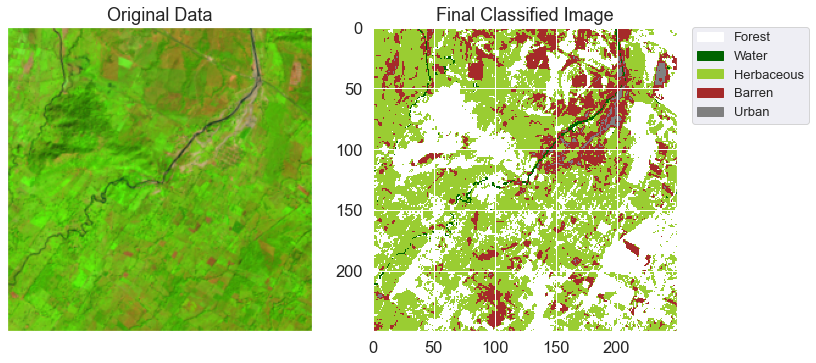

In [49]:
# Now plot the classmap next to the original image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ep.plot_rgb(landsat_xr.values,
            rgb=[4, 3, 2],
            ax=ax1)
ax1.set_title("Original Data")
im2 = ax2.imshow(class_prediction.transpose([1, 0]),
                 cmap=cmap,
                 interpolation='none')


ep.draw_legend(im_ax=im2,
               titles=final_classes)
ax2.set_title("Final Classified Image")
plt.show()

## Wrapup

We've seen how we can use `scikit-learn` to implement the Random Forest classifier for land cover classification. A couple future directions that immediately follow this tutorial include:


+ Add additional features - would using NDVI as well as the spectral bands improve our classification?
+ `scikit-learn` includes many machine learning classifiers -- are any of these better than Random Forest for our goal?
+ We've only worked using a single date of imagery -- does  the  classifier  work  as  well on a  second i mage from the same location? Different location?

We've seen how Random Forest can come up with an estimate of the classification accuracy using the "Out-of-Bag" samples. While this may be a useful metric, we will need to perform a proper accuracy assessment based on a probability sample to conclude anything about the accuracy of the entire area. With the information from the accuracy assessment, we will be able not only to tell how good the map is, but more importantly we will be able to come up with statistically defensible unbiased estimates with confidence intervals of the land cover class areas in the map. For more information, see [Olofsson, *et. al.*, 2013](http://www.sciencedirect.com/science/article/pii/S0034425712004191).

# Questions
* Why pick 500 estimators? -- based upon other work - you could play with that some

* with smaller pixels - like naip you may get into issues with shadow and such...
picking a model - maybe look to the literature to see what other people have done.

Random forest will shine if you want to add additional layers to the data (elevation, slope, etc) - random forest is nice because it isn't linear and allows for different types of data.

Notes - the data are still  coming in as  floats so may be able to remove / reduce to int16 to reduce processing?.